### Imports

In [1]:
# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']


# uses custom metis style sheet for notebooks
from IPython.core.display import HTML
HTML("""<link rel="stylesheet" href="https://soph.info/metis/nb.css" type="text/css"/>""")

#######################
#       imports       #
#######################
import pandas as pd
import seaborn as sns

# import sklearn
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle 

In [3]:
# gensim
import gensim

# keras
from keras.models import Sequential
from keras.layers import (Dense, Embedding, Reshape, Activation, 
                          SimpleRNN, LSTM, Convolution1D, 
                          MaxPooling1D, Dropout, Bidirectional)
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop


# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.
/anaconda3/envs/Metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/Metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/Metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/Metis/lib/python3.7/site-packages/tensorflo

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Cleaning df1

In [6]:
df1 = pd.read_csv('NewsArticles.csv',encoding='latin1')

In [7]:
df1 = df1[['article_id', 'publish_date', 'article_source_link', 'title',
       'subtitle', 'text']]

In [8]:
df1.head()

,article_id,publish_date,article_source_link,title,subtitle,text
0,1,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie...,"Betsy DeVos Confirmed as Education Secretary, ...",NaN,Michigan billionaire education activist Betsy ...
1,2,2017/2/7,http://abcnews.go.com/Politics/wireStory/melan...,Melania Trump Says White House Could Mean Mill...,NaN,First lady Melania Trump has said little about...
2,3,2017/2/7,http://abcnews.go.com/Politics/wireStory/trump...,"As Trump Fears Fraud, GOP Eliminates Election ...",NaN,A House committee voted on Tuesday to eliminat...
3,4,2017/2/7,http://abcnews.go.com/Politics/appeals-court-d...,Appeals Court to Decide on Challenge to Trump'...,NaN,"This afternoon, three federal judges from the ..."
4,5,2017/2/7,http://abcnews.go.com/US/23-states-winter-weat...,At Least 4 Tornadoes Reported in Southeast Lou...,NaN,At least four tornadoes touched down in Louisi...


In [9]:
df1['pub'] = df1['article_source_link'].str.split('//').str[1]

In [10]:
df1['pub2'] = df1['pub'].str.split('.').str[0]

In [11]:
df1.head()

,article_id,publish_date,article_source_link,title,subtitle,text,pub,pub2
0,1,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie...,"Betsy DeVos Confirmed as Education Secretary, ...",NaN,Michigan billionaire education activist Betsy ...,abcnews.go.com/Politics/pence-break-tie-betsy-...,abcnews
1,2,2017/2/7,http://abcnews.go.com/Politics/wireStory/melan...,Melania Trump Says White House Could Mean Mill...,NaN,First lady Melania Trump has said little about...,abcnews.go.com/Politics/wireStory/melania-trum...,abcnews
2,3,2017/2/7,http://abcnews.go.com/Politics/wireStory/trump...,"As Trump Fears Fraud, GOP Eliminates Election ...",NaN,A House committee voted on Tuesday to eliminat...,abcnews.go.com/Politics/wireStory/trump-fears-...,abcnews
3,4,2017/2/7,http://abcnews.go.com/Politics/appeals-court-d...,Appeals Court to Decide on Challenge to Trump'...,NaN,"This afternoon, three federal judges from the ...",abcnews.go.com/Politics/appeals-court-decide-c...,abcnews
4,5,2017/2/7,http://abcnews.go.com/US/23-states-winter-weat...,At Least 4 Tornadoes Reported in Southeast Lou...,NaN,At least four tornadoes touched down in Louisi...,abcnews.go.com/US/23-states-winter-weather-ale...,abcnews


In [12]:
df1.drop(['pub'],axis=1,inplace=True)

In [13]:
df1.rename({'pub2':'publication','publish_date':'date','article_source_link':'url','text':'content'},axis=1,inplace=True)

In [14]:
df1.drop(['article_id'],axis=1,inplace=True)

In [15]:
df1['title1'] = df1[['title','subtitle']].astype(str).apply(lambda x:' '.join(x),axis=1)

In [16]:
df1.drop(['title','subtitle'],axis=1,inplace=True)

In [17]:
df1.head()

,date,url,content,publication,title1
0,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie...,Michigan billionaire education activist Betsy ...,abcnews,"Betsy DeVos Confirmed as Education Secretary, ..."
1,2017/2/7,http://abcnews.go.com/Politics/wireStory/melan...,First lady Melania Trump has said little about...,abcnews,Melania Trump Says White House Could Mean Mill...
2,2017/2/7,http://abcnews.go.com/Politics/wireStory/trump...,A House committee voted on Tuesday to eliminat...,abcnews,"As Trump Fears Fraud, GOP Eliminates Election ..."
3,2017/2/7,http://abcnews.go.com/Politics/appeals-court-d...,"This afternoon, three federal judges from the ...",abcnews,Appeals Court to Decide on Challenge to Trump'...
4,2017/2/7,http://abcnews.go.com/US/23-states-winter-weat...,At least four tornadoes touched down in Louisi...,abcnews,At Least 4 Tornadoes Reported in Southeast Lou...


In [18]:

df1.rename({'title1':'title'},axis=1,inplace=True)

### Cleaning the rest if dfs

In [19]:
df2 = pd.read_csv('articles1.csv')

In [20]:
df3 = pd.read_csv('articles2.csv')

In [21]:
df4 = pd.read_csv('articles3.csv')

In [22]:
df_pre = pd.concat([df2,df3,df4],axis=0)

In [23]:
df_pre.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [24]:
df_pre.drop(['Unnamed: 0', 'id','author','year', 'month'],axis=1,inplace=True)

In [25]:
df_pre.head()

,title,publication,date,url,content
0,House Republicans Fret About Winning Their Hea...,New York Times,2016-12-31,NaN,WASHINGTON — Congressional Republicans have...
1,Rift Between Officers and Residents as Killing...,New York Times,2017-06-19,NaN,"After the bullet shells get counted, the blood..."
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,2017-01-06,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,2017-04-10,NaN,"Death may be the great equalizer, but it isn’t..."
4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,2017-01-02,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [26]:
df1.head()

,date,url,content,publication,title
0,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie...,Michigan billionaire education activist Betsy ...,abcnews,"Betsy DeVos Confirmed as Education Secretary, ..."
1,2017/2/7,http://abcnews.go.com/Politics/wireStory/melan...,First lady Melania Trump has said little about...,abcnews,Melania Trump Says White House Could Mean Mill...
2,2017/2/7,http://abcnews.go.com/Politics/wireStory/trump...,A House committee voted on Tuesday to eliminat...,abcnews,"As Trump Fears Fraud, GOP Eliminates Election ..."
3,2017/2/7,http://abcnews.go.com/Politics/appeals-court-d...,"This afternoon, three federal judges from the ...",abcnews,Appeals Court to Decide on Challenge to Trump'...
4,2017/2/7,http://abcnews.go.com/US/23-states-winter-weat...,At least four tornadoes touched down in Louisi...,abcnews,At Least 4 Tornadoes Reported in Southeast Lou...


### Full df

In [27]:
df = pd.concat([df1,df_pre],axis=0)

/anaconda3/envs/Metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [28]:
df.head()

,content,date,publication,title,url
0,Michigan billionaire education activist Betsy ...,2017/2/7,abcnews,"Betsy DeVos Confirmed as Education Secretary, ...",http://abcnews.go.com/Politics/pence-break-tie...
1,First lady Melania Trump has said little about...,2017/2/7,abcnews,Melania Trump Says White House Could Mean Mill...,http://abcnews.go.com/Politics/wireStory/melan...
2,A House committee voted on Tuesday to eliminat...,2017/2/7,abcnews,"As Trump Fears Fraud, GOP Eliminates Election ...",http://abcnews.go.com/Politics/wireStory/trump...
3,"This afternoon, three federal judges from the ...",2017/2/7,abcnews,Appeals Court to Decide on Challenge to Trump'...,http://abcnews.go.com/Politics/appeals-court-d...
4,At least four tornadoes touched down in Louisi...,2017/2/7,abcnews,At Least 4 Tornadoes Reported in Southeast Lou...,http://abcnews.go.com/US/23-states-winter-weat...


In [29]:
df.to_csv('df_for_generation.csv')

In [30]:
df = pd.read_csv('df_for_generation.csv')

In [31]:
df.head()

,Unnamed: 0,content,date,publication,title,url
0,0,Michigan billionaire education activist Betsy ...,2017/2/7,abcnews,"Betsy DeVos Confirmed as Education Secretary, ...",http://abcnews.go.com/Politics/pence-break-tie...
1,1,First lady Melania Trump has said little about...,2017/2/7,abcnews,Melania Trump Says White House Could Mean Mill...,http://abcnews.go.com/Politics/wireStory/melan...
2,2,A House committee voted on Tuesday to eliminat...,2017/2/7,abcnews,"As Trump Fears Fraud, GOP Eliminates Election ...",http://abcnews.go.com/Politics/wireStory/trump...
3,3,"This afternoon, three federal judges from the ...",2017/2/7,abcnews,Appeals Court to Decide on Challenge to Trump'...,http://abcnews.go.com/Politics/appeals-court-d...
4,4,At least four tornadoes touched down in Louisi...,2017/2/7,abcnews,At Least 4 Tornadoes Reported in Southeast Lou...,http://abcnews.go.com/US/23-states-winter-weat...


In [32]:
df['title+content'] = df[['title','content']].astype(str).apply(lambda x:' '.join(x),axis=1)

In [33]:
df['publication'].value_counts()

Breitbart              23781
New York Post          17493
NPR                    11992
CNN                    11488
Washington Post        11114
Reuters                10710
Guardian                8681
New York Times          7803
Atlantic                7179
Business Insider        6757
National Review         6203
Talking Points Memo     5214
Vox                     4947
Buzzfeed News           4854
Fox News                4354
www                     2505
tass                     485
abcnews                  474
europe                   360
Name: publication, dtype: int64

In [34]:
df['publication'] = df['publication'].replace({'www':'CNN'})

In [35]:
df[['content','publication','title+content']] = df[['content','publication','title+content']].astype('str')

In [36]:
df['content'] = df['content'].astype('str')

In [37]:
df['title'] = df['title'].astype('str')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146394 entries, 0 to 146393
Data columns (total 7 columns):
Unnamed: 0       146394 non-null int64
content          146394 non-null object
date             143753 non-null object
publication      146394 non-null object
title            146394 non-null object
url              89383 non-null object
title+content    146394 non-null object
dtypes: int64(1), object(6)
memory usage: 7.8+ MB


In [39]:
df['url'] = df['url'].fillna('No url')

### Processing text data 

In [40]:
import re 
import string 

In [41]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

In [42]:
df['content'] = df['content'].map(alphanumeric).map(punc_lower)

In [43]:
df['title'] = df['title'].map(alphanumeric).map(punc_lower)

In [44]:
df['title+content'] = df['title+content'].map(alphanumeric).map(punc_lower)

### LSTM Modeling 

In [45]:
from keras.preprocessing.sequence import pad_sequences

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping


In [48]:
# The maximum number of words to be used. (most frequent)
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
MAX_NB_WORDS = 30000


In [49]:
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, filters="""!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',""")
tokenizer.fit_on_texts(df['title+content'].values)
word_index = tokenizer.word_index

In [50]:
# Convert tokenized sentences to sequence format
X = tokenizer.texts_to_sequences(df['title+content'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [51]:
Y = pd.get_dummies(df['publication']).values

In [52]:
Yx = pd.get_dummies(df['publication'])

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(117115, 250) (117115, 18)
(29279, 250) (29279, 18)


In [54]:
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=40, embeddings_initializer='glorot_uniform', input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(18, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()

2019-09-09 09:20:58,936 : WARNING : From /anaconda3/envs/Metis/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



2019-09-09 09:20:59,136 : WARNING : From /anaconda3/envs/Metis/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2019-09-09 09:20:59,191 : WARNING : From /anaconda3/envs/Metis/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



2019-09-09 09:20:59,277 : WARNING : From /anaconda3/envs/Metis/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-09-09 09:20:59,302 : WARNING : From /anaconda3/envs/Metis/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-09-09 09:21:00,018 : WARNING : From /anaconda3/envs/Metis/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



2019-09-09 09:21:00,063 : WARNING : From /anaconda3/envs/Metis/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 40)           1200000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 40)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_1 (Dense)              (None, 18)                1818      
Total params: 1,258,218
Trainable params: 1,258,218
Non-trainable params: 0
_________________________________________________________________


In [55]:
epochs = 10
batch_size = 64


model.fit(X_train, Y_train, batch_size=256, epochs=epochs, 
              validation_data=(X_test, Y_test))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-09-09 09:21:00,466 : WARNING : From /anaconda3/envs/Metis/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 117115 samples, validate on 29279 samples
Epoch 1/10
117115/117115 [==============================] - 1896s 16ms/step - loss: 2.0563 - acc: 0.3403 - val_loss: 1.6671 - val_acc: 0.4592
Epoch 2/10
117115/117115 [==============================] - 1907s 16ms/step - loss: 1.6129 - acc: 0.4836 - val_loss: 1.5333 - val_acc: 0.5127
Epoch 3/10
117115/117115 [==============================] - 1944s 17ms/step - loss: 1.4369 - acc: 0.5453 - val_loss: 1.3867 - val_acc: 0.5652
Epoch 4/10
117115/117115 [==============================] - 1723s 15ms/step - loss: 1.2962 - acc: 0.5939 - val_loss: 1.3000 - val_acc: 0.5965
Epoch 5/10
117115/117115 [==============================] - 1930s 16ms/step - loss: 1.1285 - acc: 0.6477 - val_loss: 1.1084 - val_acc: 0.6558
Epoch 6/10
117115/117115 [==============================] - 5611s 48ms/step - loss: 1.0285 - acc: 0.6793 - val_loss: 1.0656 - val_acc: 0.6681
Epoch 7/10
117115/117115 [==============================] - 1878s 16ms/step - loss: 0.9069 - acc:

In [56]:
hidden_features = model.predict(X_test)

In [57]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [58]:
pca = PCA(n_components=18)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result[:5000])

Variance PCA: 0.9999999403953552
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.390s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000004
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.165478
[t-SNE] KL divergence after 1000 iterations: 0.631211


In [59]:
np_utils.to_categorical(Y_test[1], num_classes=18)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0

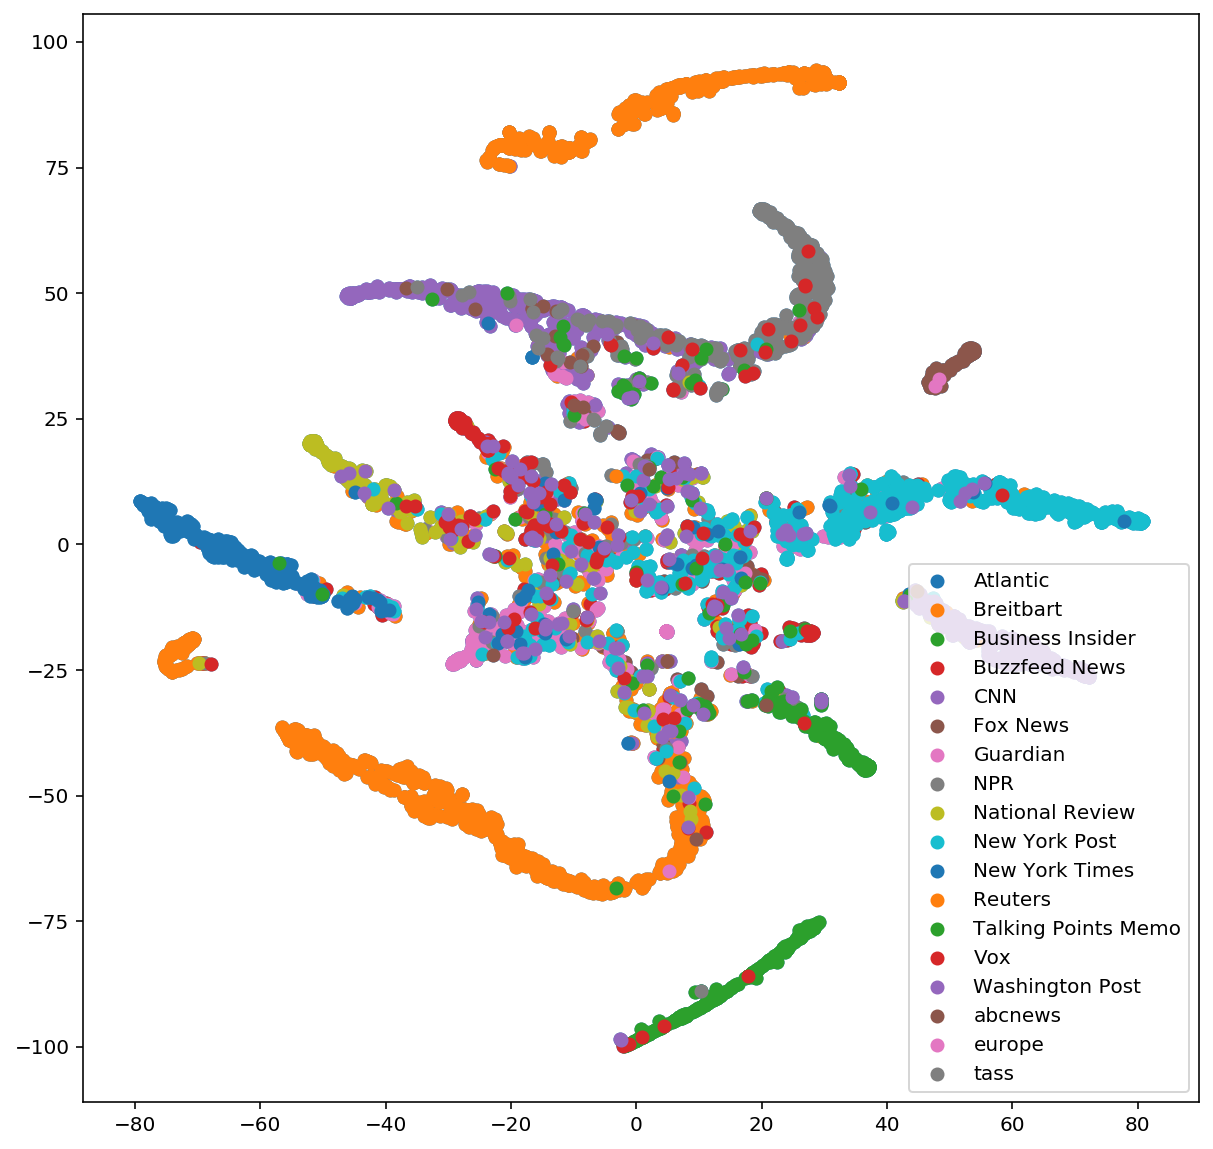

In [60]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = np_utils.to_categorical(Y_test[:5000])
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(18):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend(Yx.columns)
plt.show()

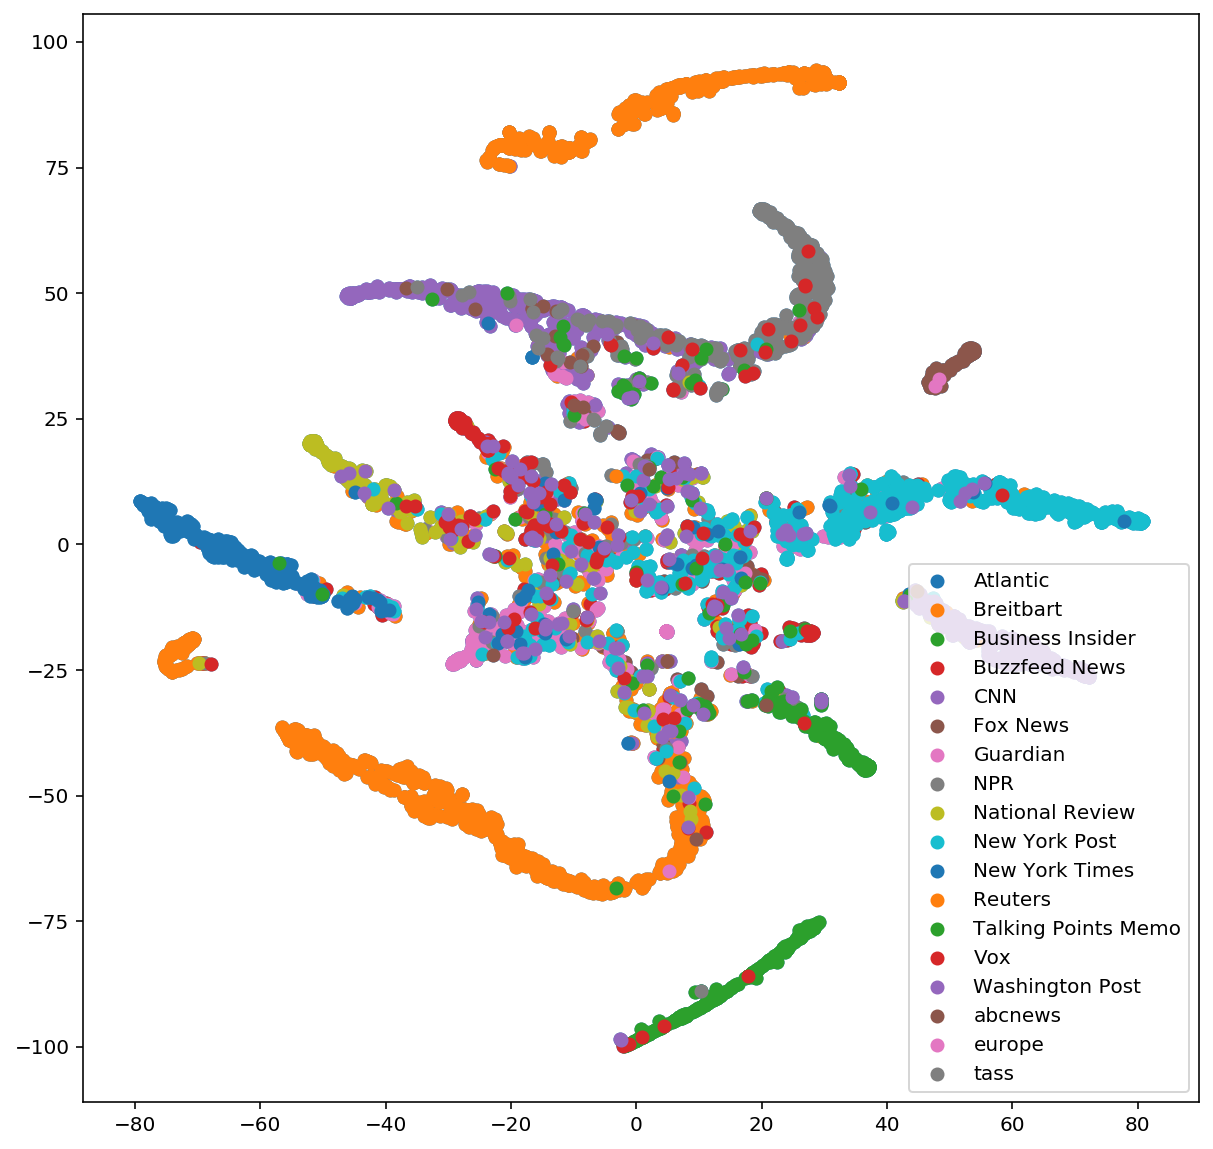

In [61]:
y_test_cat = np_utils.to_categorical(Y_test[:5000])
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(18):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend(Yx.columns)
plt.show()

In [62]:
nytimes = ['WASHINGTON — President Trump said on Tuesday that Chinese manufacturing would “crumble” if the country did not agree to the United States’ trade terms, as newly released data showed his trade war was washing back to American shores and hurting the factories that the president has aimed to protect.Days after new tariffs went into effect on both sides of the Pacific, a closely watched index of American manufacturing activity fell to 49.1 from 51.2, signaling a contraction in United States factory activity for the first time since 2016. The companies responding to the Institute for Supply Management survey, which the index is based on, cited shrinking export orders as a result of the trade dispute, as well as the challenge of moving supply chains out of China to avoid the tariffs.The manufacturing sector’s struggles are likely to increase as the world’s two largest economies continue to escalate their trade fight. On Sunday, Mr. Trump placed a new 15 percent tariff on a range of consumer goods, including clothing, lawn mowers, sewing machines, food and jewelry, and Beijing retaliated by increasing tariffs on $75 billion worth of American products. China also said on Monday that it was filing a complaint at the World Trade Organization over Mr. Trump’s new tariffs.Markets sank on weaker economic news and worries about the trade war. The S&P 500 was down about 0.9 percent, with particular weakness in industrial and energy stocks']

In [63]:
Yx.columns

Index(['Atlantic', 'Breitbart', 'Business Insider', 'Buzzfeed News', 'CNN', 'Fox News', 'Guardian', 'NPR', 'National Review', 'New York Post', 'New York Times', 'Reuters', 'Talking Points Memo', 'Vox', 'Washington Post', 'abcnews', 'europe', 'tass'], dtype='object')

In [64]:
seq = tokenizer.texts_to_sequences(nytimes)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels  = ['Atlantic', 'Breitbart', 'Business Insider', 'Buzzfeed News', 'CNN', 'Fox News', 'Guardian', 'NPR', 'National Review', 'New York Post', 'New York Times', 'Reuters', 'Talking Points Memo', 'Vox', 'Washington Post', 'abcnews', 'europe', 'tass']
print(pred, labels[np.argmax(pred)])


[[1.36145391e-03 1.23865075e-01 8.90534429e-05 3.03085637e-03
  7.70739764e-02 1.06729497e-03 3.98724414e-02 3.86702199e-03
  2.03213189e-03 2.29110643e-02 7.07000136e-01 6.86747779e-04
  5.82997035e-03 1.01030373e-03 4.05633170e-03 4.68920596e-04
  7.60100238e-06 5.76959644e-03]] New York Times


In [65]:
print(pred, labels[np.argmin(pred)])

[[1.36145391e-03 1.23865075e-01 8.90534429e-05 3.03085637e-03
  7.70739764e-02 1.06729497e-03 3.98724414e-02 3.86702199e-03
  2.03213189e-03 2.29110643e-02 7.07000136e-01 6.86747779e-04
  5.82997035e-03 1.01030373e-03 4.05633170e-03 4.68920596e-04
  7.60100238e-06 5.76959644e-03]] europe


### DBSCAN 

In [66]:
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
